In [19]:
!pip install segmentation_models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:

from tqdm import tqdm 
import os 
import keras
import numpy as np 
import tensorflow as tf


# Data 
import scipy.ndimage as mp
from glob import glob
import pathlib
import cv2 as cv
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
import tensorflow.image as tfi

# Model prepare
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt

#from rembg import remove
from PIL import Image

import subprocess
from IPython.display import FileLink, display

from keras.utils import  Sequence


In [21]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as smp;

env: SM_FRAMEWORK=tf.keras


In [22]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

## Data preprocessing

In [23]:

def del_mask_img(images, masks):
    for im, ma in tqdm(zip(images, masks), total = len(images)):
        #sleep(0.00001)
        mask = load_img(ma) 
        mask= img_to_array(mask)[:,:,0] #np
        mask = np.where(mask > 250, 1, 0) # 68-0 253-1 artefact after saving np.array to mask
        m_sum = np.sum(mask) 
        mask_to_img_relation = m_sum/(mask.shape[0]*mask.shape[1])
        if mask_to_img_relation >= 0.8 or mask_to_img_relation <= 0.3:
            masks.remove(ma)
            images.remove(im)
    return images, masks

In [7]:
# создание ссылок на изображения и маски
img = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/clip_img/*/*/*'))
mask = sorted(glob(r'../input/mask-aisegmentcom-matting-human-datasets/masks/*/*/*')) # corected masks
first_len = len(img)

In [9]:
img, mask = del_mask_img(img, mask)
print(f"Dataset size - {first_len}"
f"\nDatasate size after removal outliers - {len(img)}"
f"\nDaraset reduction - {100.00 - np.round(len(img)*100/first_len,2)}%")

 97%|█████████▋| 33151/34289 [07:57<00:16, 69.40it/s]

Dataset size - 34426
Datasate size after removal outliers - 33151
Daraset reduction - 3.700000000000003%


## Visualisation

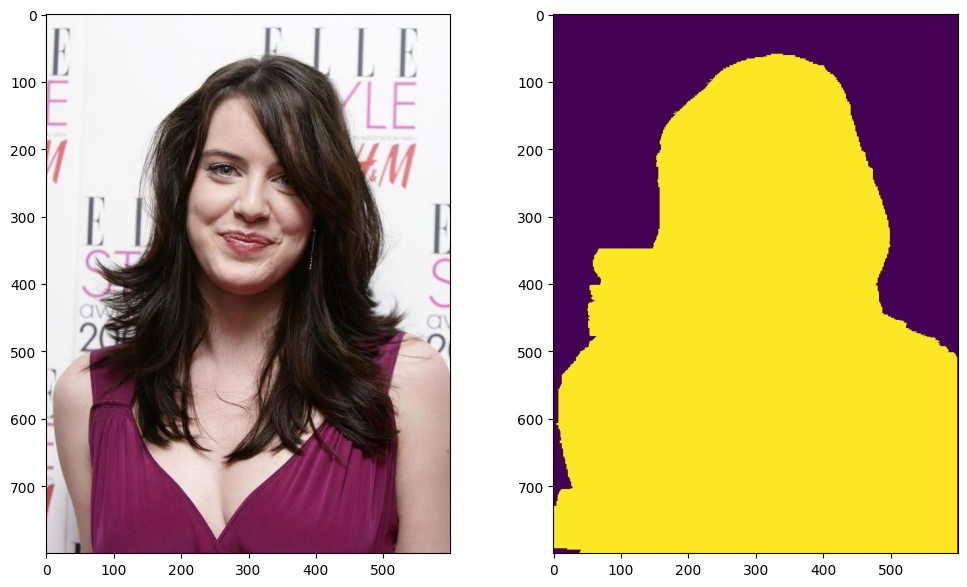

In [10]:
plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
im = plt.imread(img[99])
plt.imshow(im)
plt.subplot(1,2,2)
m = plt.imread(mask[99])
plt.imshow(m)
plt.show()

## Data Loader 
for optimal use of RAM since all the images will not fit into RAM


In [11]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images, labels, batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=None, dim=(224,224,3), shuffle=True):
        
        super().__init__(workers, use_multiprocessing, max_queue_size)  #**kwargs)
        
        self.use_multiprocessing = use_multiprocessing
        self.workers = workers
        self.max_queue_size = max_queue_size
        
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end() # 

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
            #Store class
            label = load_img(self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label >= 250
            #label = label == 253
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

## Visualisation Learning

In [12]:
def ShowImage(image, title=None, cmap=None):
    #возвращает изображение из входа матрицы
    plt.imshow(image, cmap=cmap)
    if title is not None : plt.title(title)
    plt.axis('off')
    
class ShowProgress(Callback):
    def __init__(self, valid):
        self.valid = valid
        
    
    def on_epoch_end(self, epoch, logs):
        #ax = plt.axes()
        #ax.set_facecolor("gray")
        
        plt.figure(figsize=(15,8))
        #i = np.random.randint(valid.batch_size-1)
        
        img = valid[0][0][0:3] # так как метод предикт принимает только от 2х и более картинок
        pred_mask = self.model.predict(img)[0] #[i-1]
        
        pred_mask = np.array(pred_mask, dtype="uint8").reshape(224,224)
        mapping = cv.bitwise_and(img[0],img[0],mask=pred_mask)#[0]  i-2 i-2

        plt.subplot(1,4,1)
        ShowImage(img[0],title="True IMG")
    
        plt.subplot(1,4,2)
        ShowImage(pred_mask, title="Predicted Mask")
    
        plt.subplot(1,4,3)
        ShowImage(valid[0][1][0].reshape(224, 224), title="True Mask") #1!!!
    
        plt.subplot(1,4,4)
        ShowImage(mapping, title="Mapping Mask")
    
        plt.tight_layout()
        plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(img, mask, test_size=0.30, random_state=44)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=44)

In [14]:
generator = DataGenerator(X_train, y_train, batch_size=32, dim=(224,224,3),shuffle=True)
valid = DataGenerator(X_test ,y_test, batch_size=32, dim=(224,224,3), shuffle=True)

## Learning

In [16]:
callback = [EarlyStopping(
    monitor='IoU', #
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=30
), ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1.e-08), 
            ShowProgress(valid)]


In [17]:
BACKBONE = 'efficientnetb0'
segmodel = smp.FPN(backbone_name = BACKBONE, classes=1, activation='relu',encoder_weights ='imagenet')

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/40


I0000 00:00:1734522938.021701     118 service.cc:145] XLA service 0x7dcb44001350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734522938.021789     118 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734523019.327376     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/stepms/step - IoU: 0.5055 - accuracy: 0.9594 - loss: 0.278


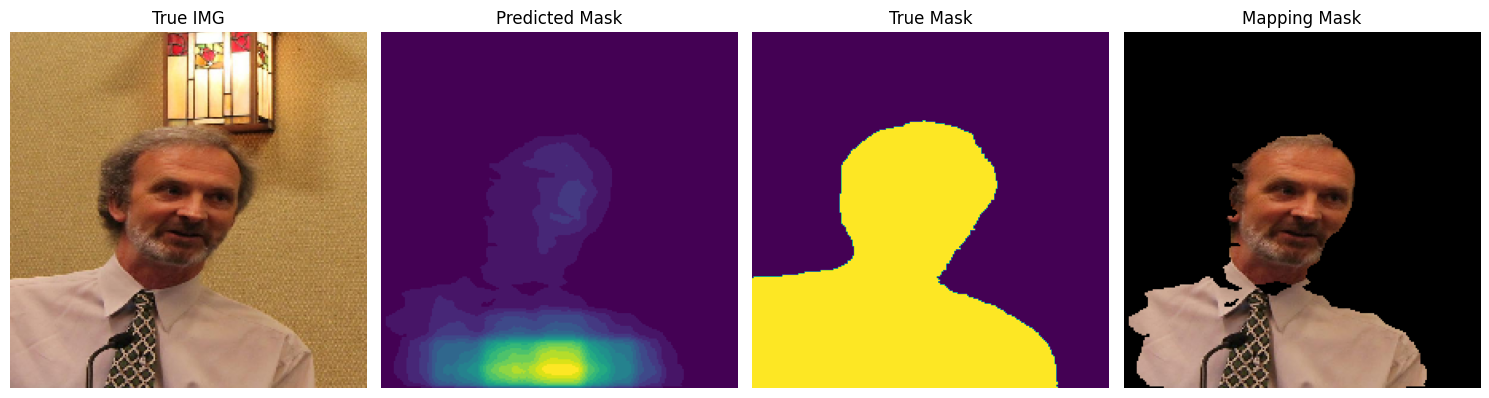

725/725 ━━━━━━━━━━━━━━━━━━━━ 761s 872ms/step - IoU: 0.5053 - accuracy: 0.9594 - loss: 0.2780 - val_IoU: 0.5246 - val_accuracy: 0.9695 - val_loss: 0.1060 - learning_rate: 0.0010
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.5732 - accuracy: 0.9740 - loss: 0.088


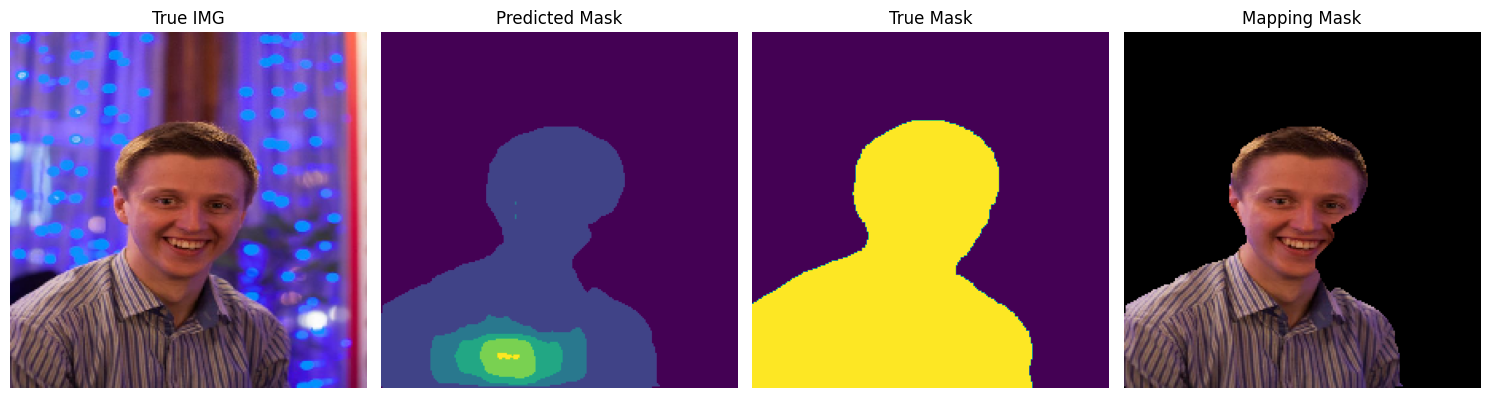

725/725 ━━━━━━━━━━━━━━━━━━━━ 425s 582ms/step - IoU: 0.5729 - accuracy: 0.9740 - loss: 0.0885 - val_IoU: 0.6091 - val_accuracy: 0.9784 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.5935 - accuracy: 0.9770 - loss: 0.075


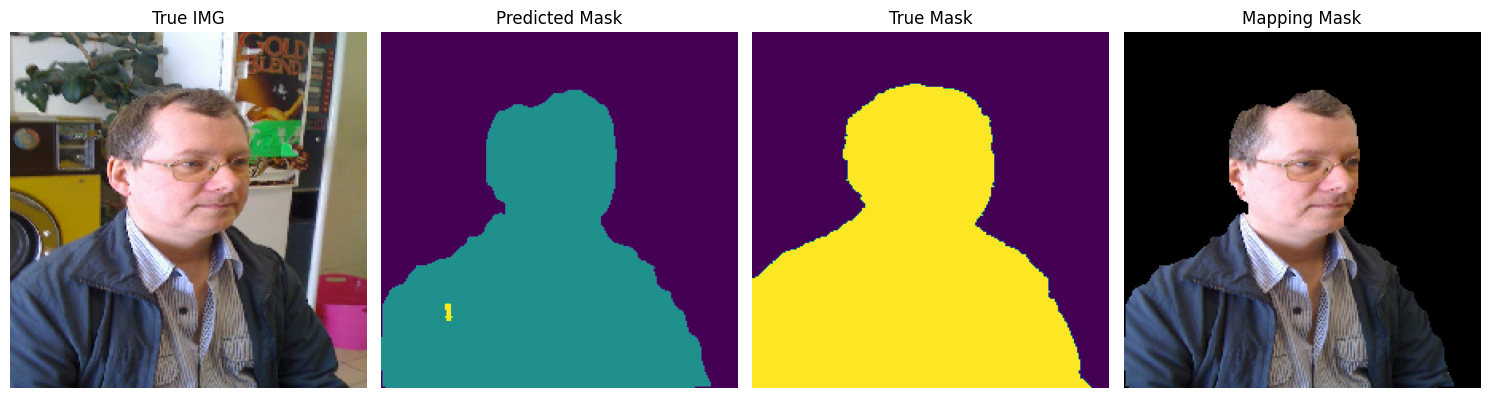

725/725 ━━━━━━━━━━━━━━━━━━━━ 424s 581ms/step - IoU: 0.5932 - accuracy: 0.9770 - loss: 0.0756 - val_IoU: 0.4886 - val_accuracy: 0.9647 - val_loss: 0.1269 - learning_rate: 0.0010
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step/step - IoU: 0.6310 - accuracy: 0.9797 - loss: 0.064


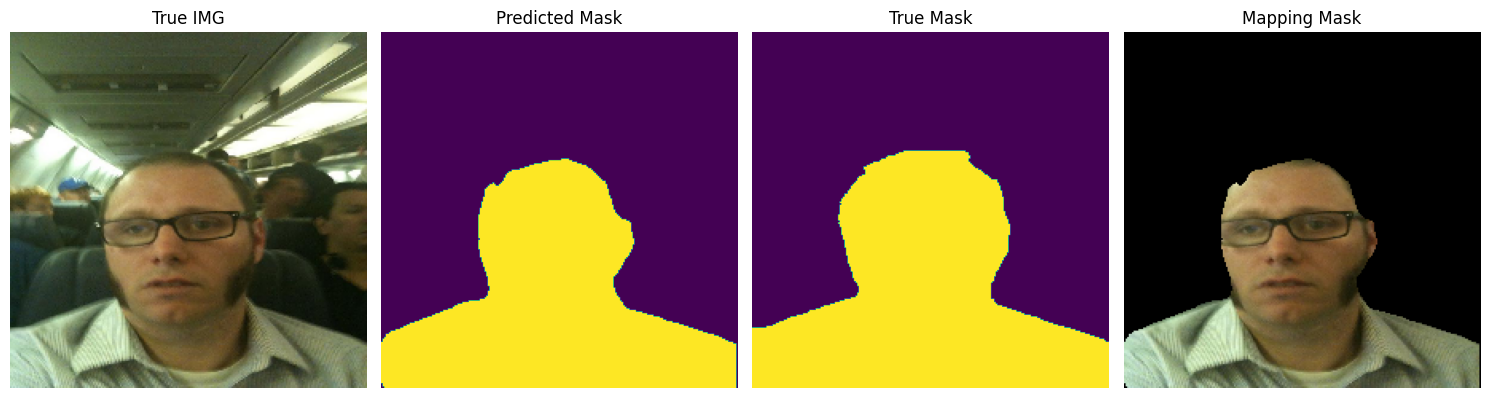

725/725 ━━━━━━━━━━━━━━━━━━━━ 427s 585ms/step - IoU: 0.6307 - accuracy: 0.9797 - loss: 0.0644 - val_IoU: 0.6438 - val_accuracy: 0.9814 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.6597 - accuracy: 0.9827 - loss: 0.053


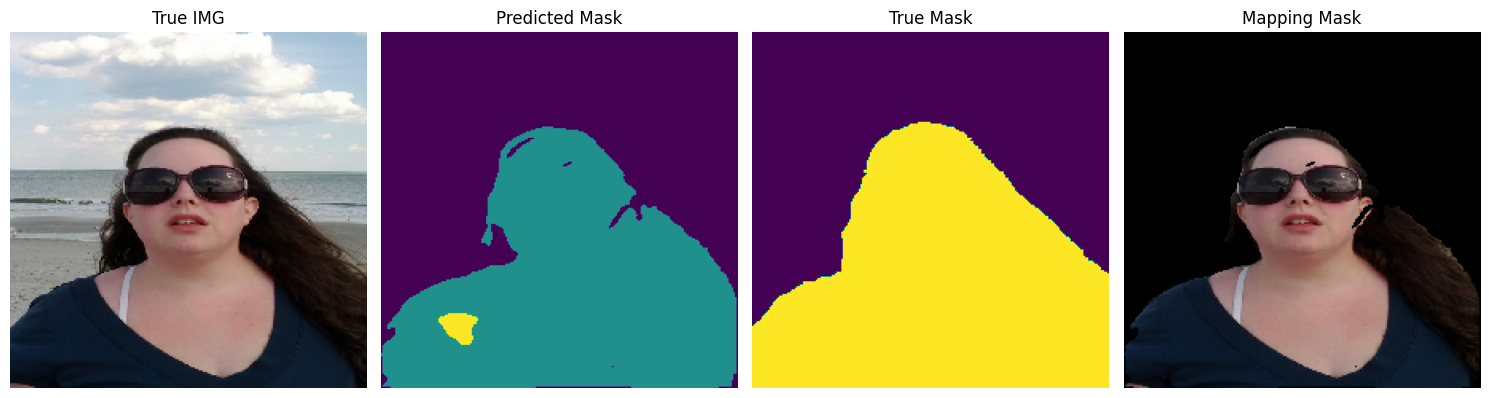

725/725 ━━━━━━━━━━━━━━━━━━━━ 425s 582ms/step - IoU: 0.6594 - accuracy: 0.9827 - loss: 0.0539 - val_IoU: 0.6806 - val_accuracy: 0.9842 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.6790 - accuracy: 0.9847 - loss: 0.047


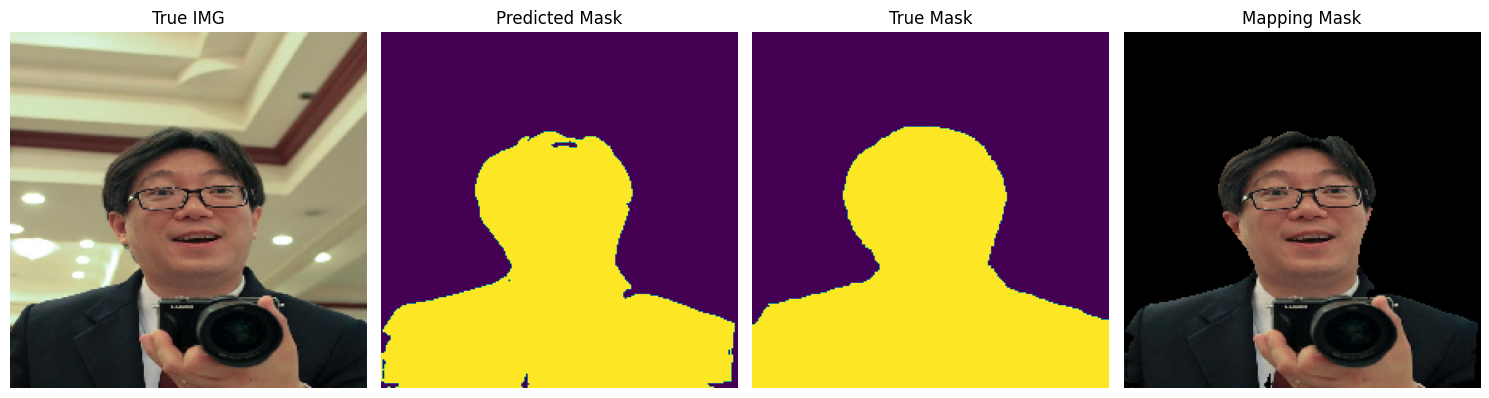

725/725 ━━━━━━━━━━━━━━━━━━━━ 425s 582ms/step - IoU: 0.6788 - accuracy: 0.9847 - loss: 0.0475 - val_IoU: 0.6983 - val_accuracy: 0.9854 - val_loss: 0.0466 - learning_rate: 0.0010
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7071 - accuracy: 0.9864 - loss: 0.041


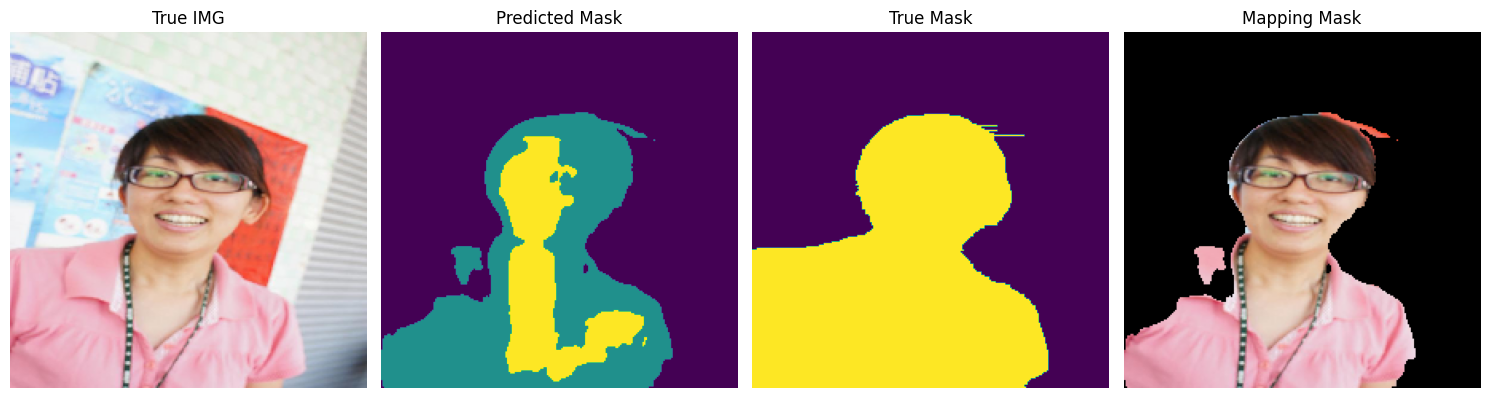

725/725 ━━━━━━━━━━━━━━━━━━━━ 423s 580ms/step - IoU: 0.7068 - accuracy: 0.9864 - loss: 0.0418 - val_IoU: 0.6267 - val_accuracy: 0.9799 - val_loss: 0.0981 - learning_rate: 0.0010
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.6702 - accuracy: 0.9838 - loss: 0.051


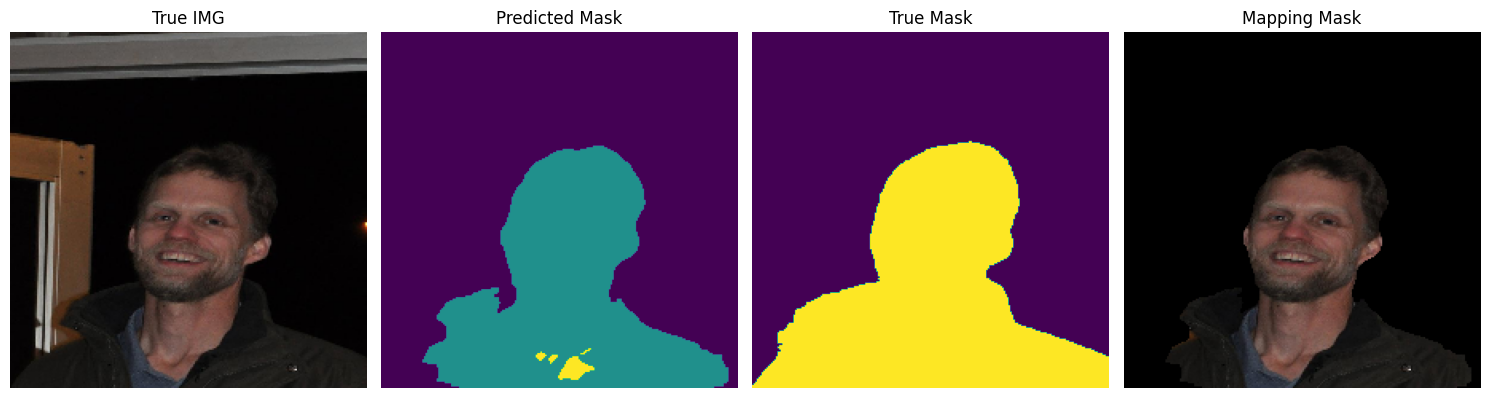

725/725 ━━━━━━━━━━━━━━━━━━━━ 423s 580ms/step - IoU: 0.6699 - accuracy: 0.9838 - loss: 0.0516 - val_IoU: 0.7013 - val_accuracy: 0.9856 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7194 - accuracy: 0.9875 - loss: 0.037


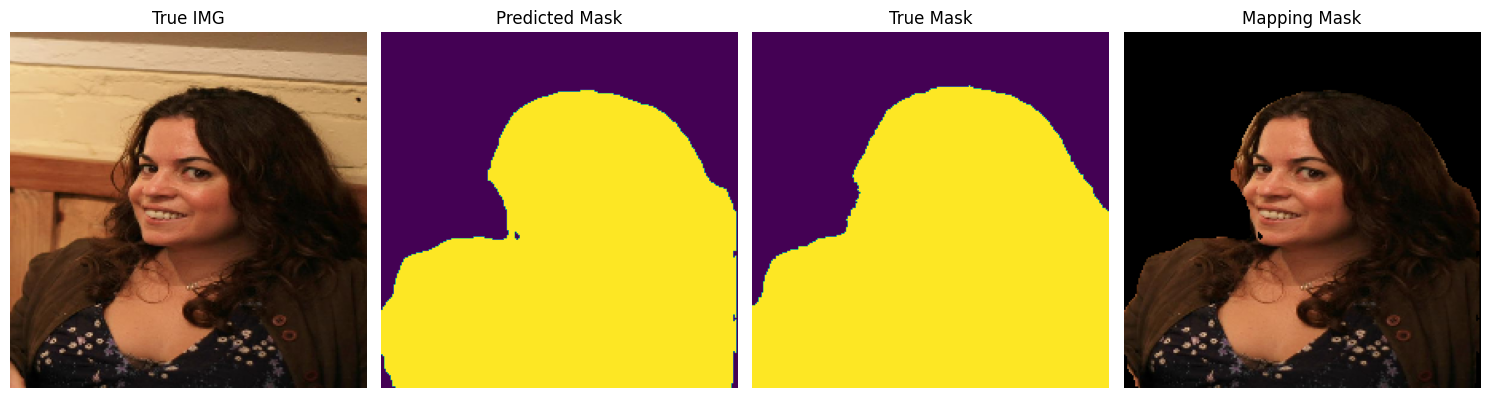

725/725 ━━━━━━━━━━━━━━━━━━━━ 426s 584ms/step - IoU: 0.7192 - accuracy: 0.9875 - loss: 0.0379 - val_IoU: 0.6782 - val_accuracy: 0.9840 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.6924 - accuracy: 0.9858 - loss: 0.044


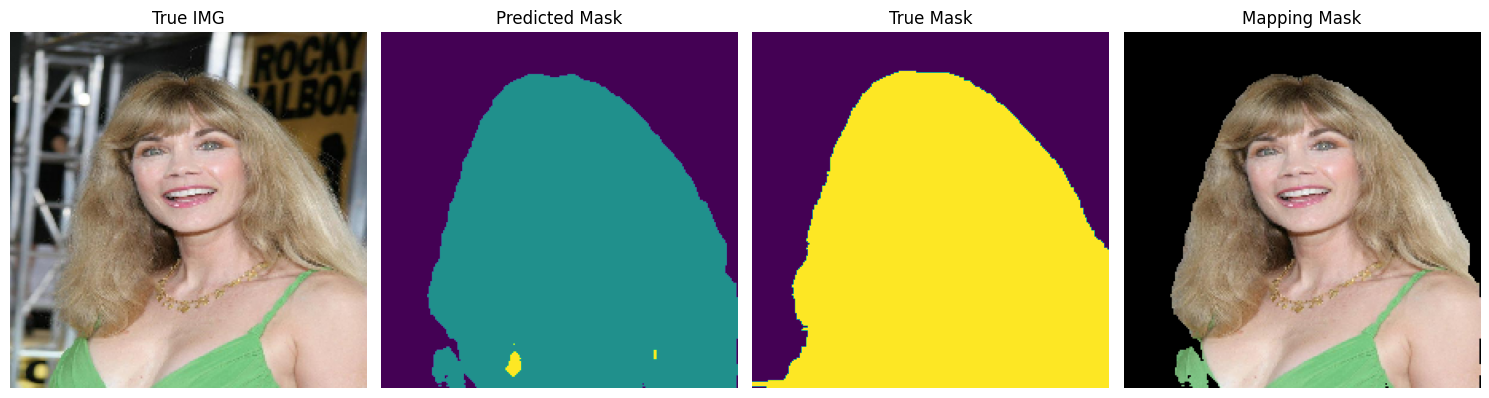

725/725 ━━━━━━━━━━━━━━━━━━━━ 425s 582ms/step - IoU: 0.6921 - accuracy: 0.9858 - loss: 0.0440 - val_IoU: 0.7330 - val_accuracy: 0.9877 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7286 - accuracy: 0.9881 - loss: 0.035


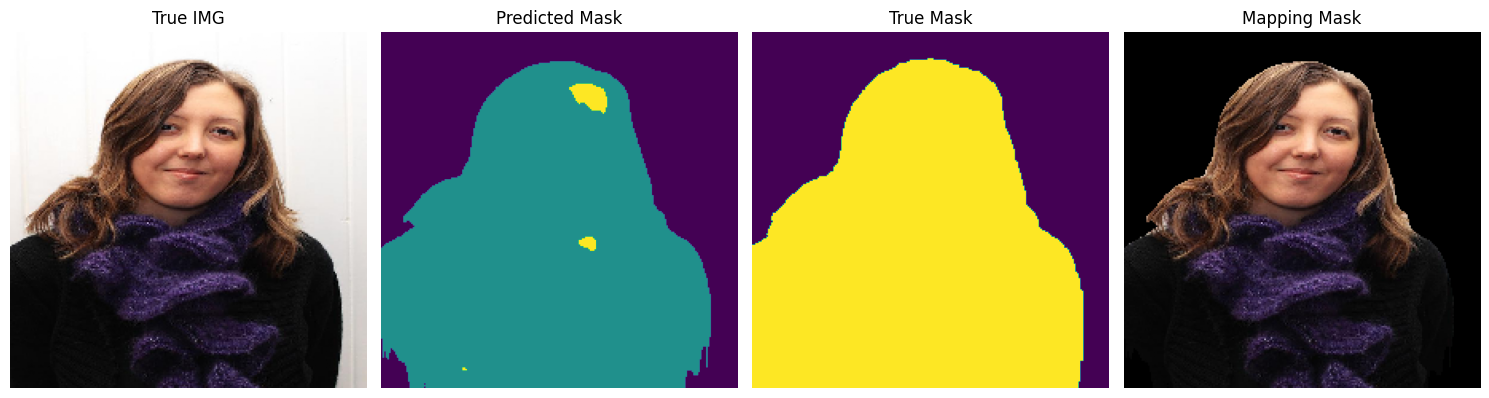

725/725 ━━━━━━━━━━━━━━━━━━━━ 432s 592ms/step - IoU: 0.7283 - accuracy: 0.9881 - loss: 0.0355 - val_IoU: 0.7105 - val_accuracy: 0.9863 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step/step - IoU: 0.6924 - accuracy: 0.9849 - loss: 0.046


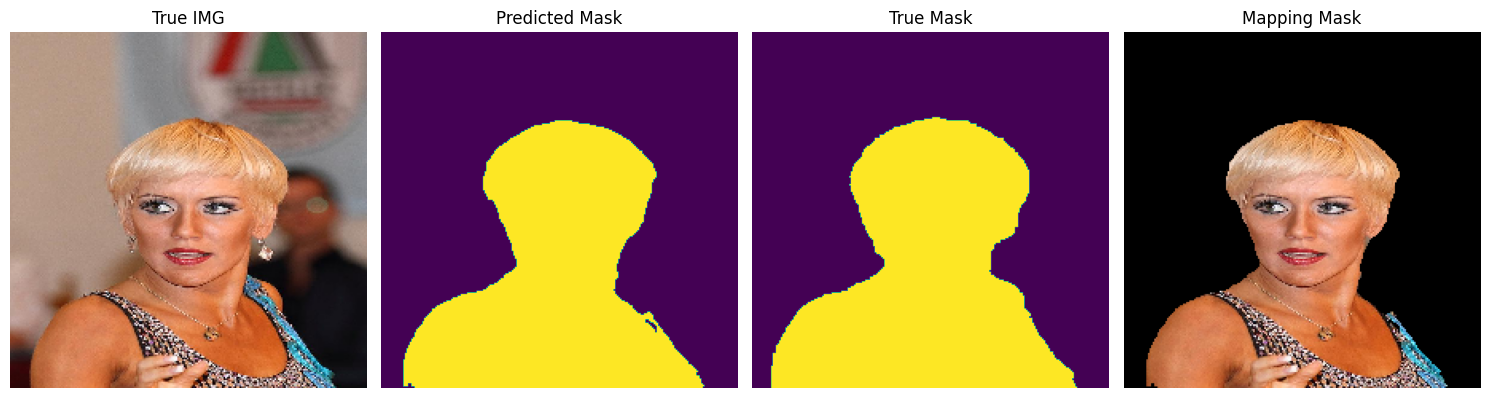

725/725 ━━━━━━━━━━━━━━━━━━━━ 422s 578ms/step - IoU: 0.6922 - accuracy: 0.9849 - loss: 0.0469 - val_IoU: 0.7242 - val_accuracy: 0.9872 - val_loss: 0.0405 - learning_rate: 3.0000e-04
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.7304 - accuracy: 0.9882 - loss: 0.035


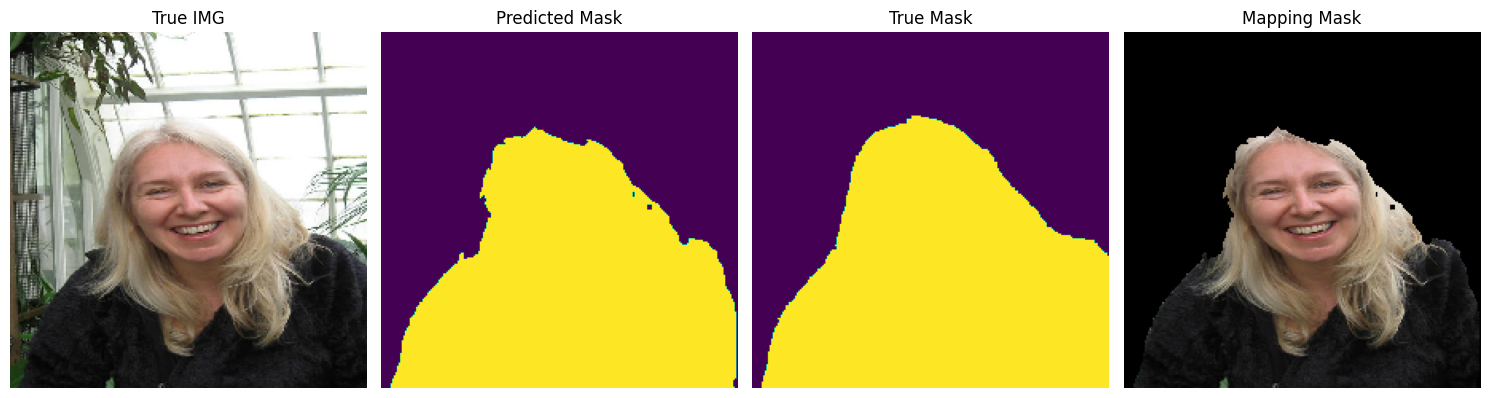

725/725 ━━━━━━━━━━━━━━━━━━━━ 423s 579ms/step - IoU: 0.7301 - accuracy: 0.9882 - loss: 0.0350 - val_IoU: 0.7036 - val_accuracy: 0.9858 - val_loss: 0.0455 - learning_rate: 3.0000e-04
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.7109 - accuracy: 0.9869 - loss: 0.039


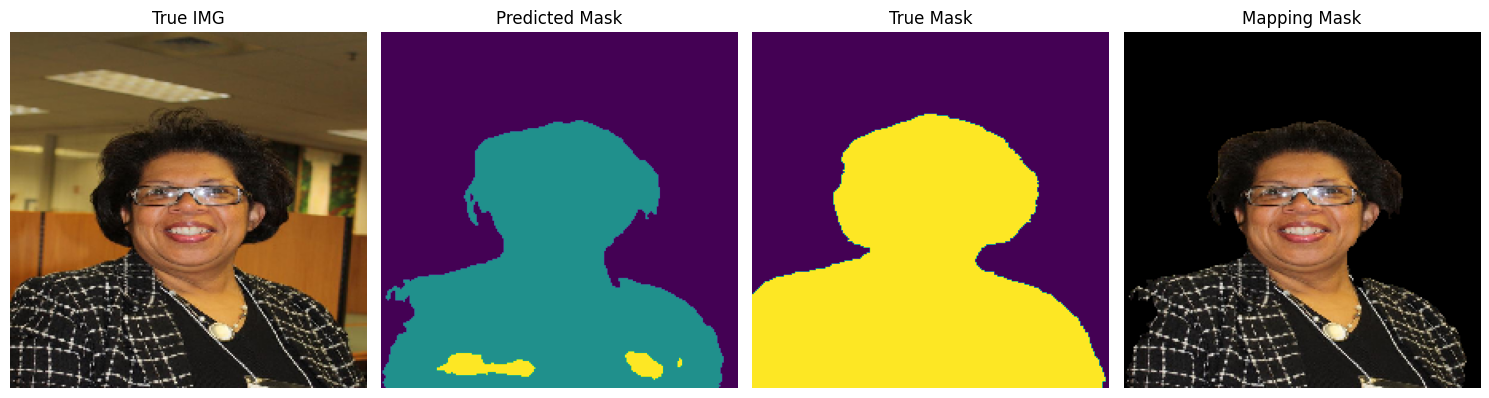

725/725 ━━━━━━━━━━━━━━━━━━━━ 425s 582ms/step - IoU: 0.7106 - accuracy: 0.9869 - loss: 0.0391 - val_IoU: 0.7282 - val_accuracy: 0.9874 - val_loss: 0.0398 - learning_rate: 9.0000e-05
Epoch 16/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step/step - IoU: 0.7328 - accuracy: 0.9884 - loss: 0.034


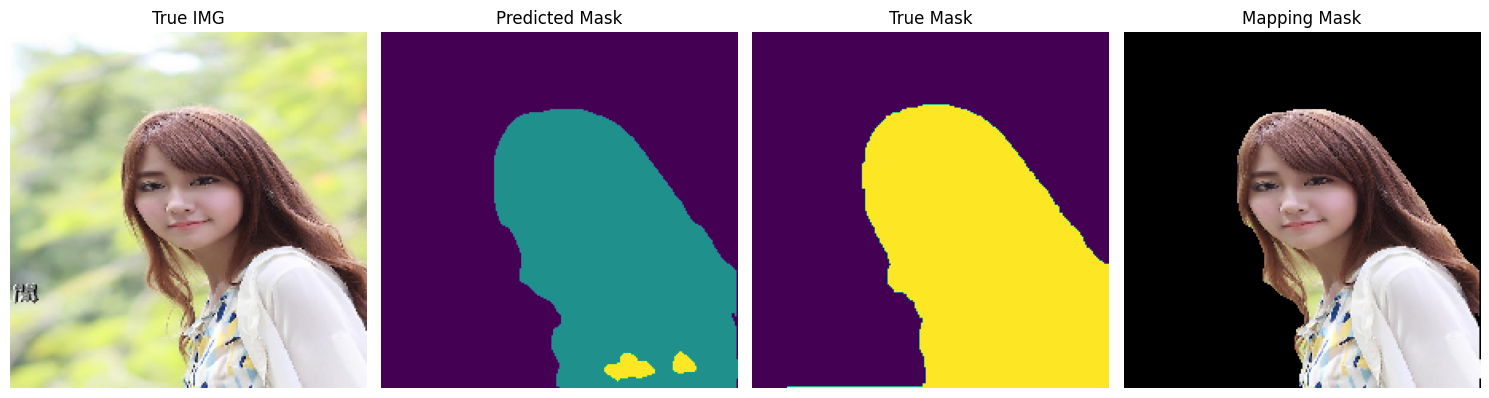

725/725 ━━━━━━━━━━━━━━━━━━━━ 424s 581ms/step - IoU: 0.7325 - accuracy: 0.9884 - loss: 0.0344 - val_IoU: 0.7375 - val_accuracy: 0.9880 - val_loss: 0.0383 - learning_rate: 9.0000e-05
Epoch 17/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step/step - IoU: 0.7403 - accuracy: 0.9888 - loss: 0.032


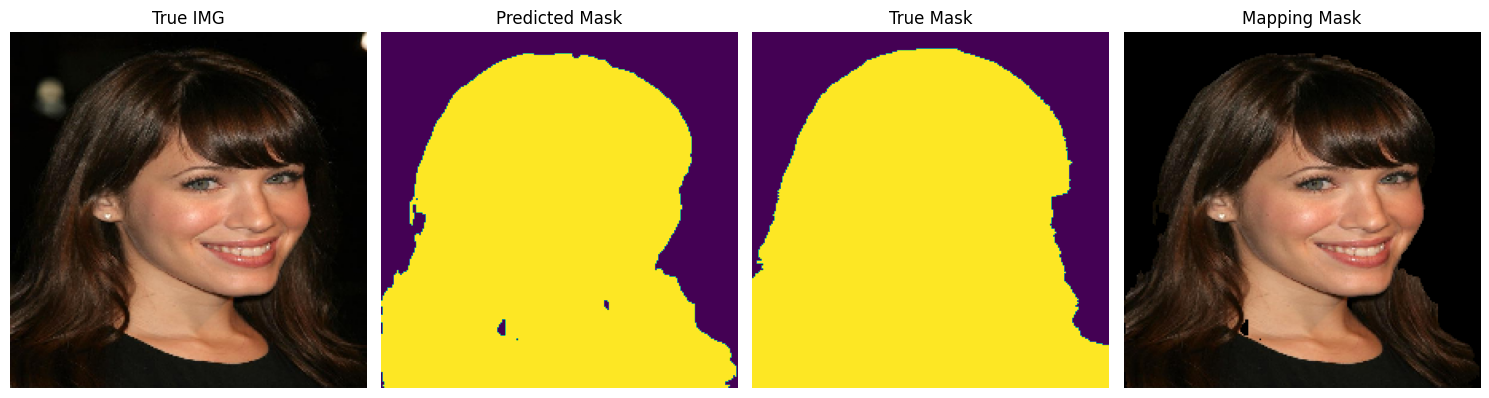

725/725 ━━━━━━━━━━━━━━━━━━━━ 425s 583ms/step - IoU: 0.7401 - accuracy: 0.9888 - loss: 0.0323 - val_IoU: 0.7395 - val_accuracy: 0.9881 - val_loss: 0.0380 - learning_rate: 9.0000e-05
Epoch 18/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step/step - IoU: 0.7466 - accuracy: 0.9893 - loss: 0.030


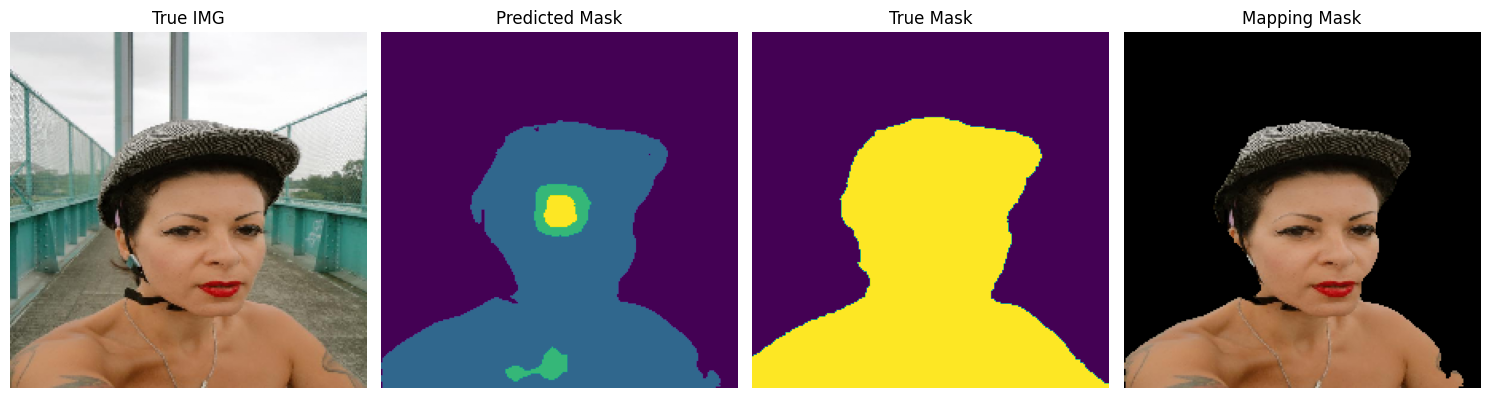

725/725 ━━━━━━━━━━━━━━━━━━━━ 423s 580ms/step - IoU: 0.7464 - accuracy: 0.9893 - loss: 0.0308 - val_IoU: 0.7465 - val_accuracy: 0.9886 - val_loss: 0.0378 - learning_rate: 9.0000e-05
Epoch 19/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step/step - IoU: 0.7496 - accuracy: 0.9894 - loss: 0.029


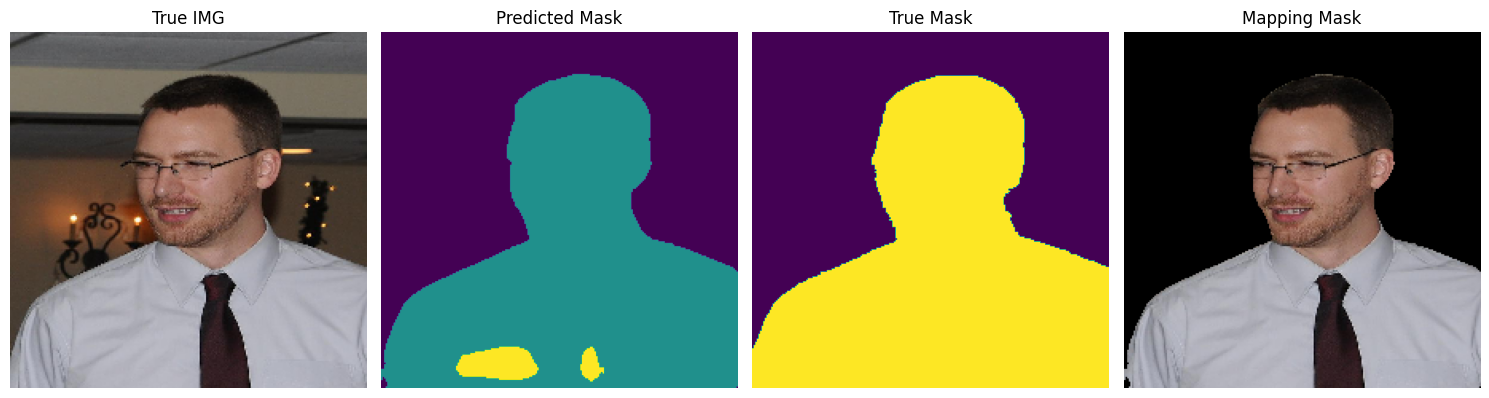

725/725 ━━━━━━━━━━━━━━━━━━━━ 432s 592ms/step - IoU: 0.7494 - accuracy: 0.9894 - loss: 0.0299 - val_IoU: 0.7493 - val_accuracy: 0.9887 - val_loss: 0.0378 - learning_rate: 9.0000e-05
Epoch 20/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step/step - IoU: 0.7559 - accuracy: 0.9898 - loss: 0.028


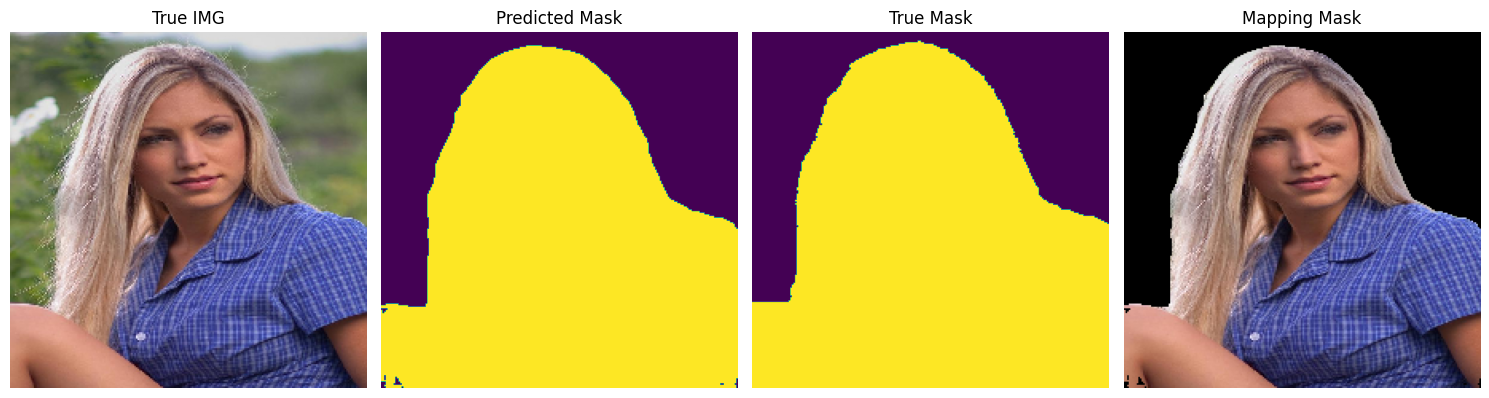

725/725 ━━━━━━━━━━━━━━━━━━━━ 422s 578ms/step - IoU: 0.7557 - accuracy: 0.9898 - loss: 0.0285 - val_IoU: 0.7495 - val_accuracy: 0.9887 - val_loss: 0.0371 - learning_rate: 9.0000e-05
Epoch 21/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.7575 - accuracy: 0.9899 - loss: 0.027


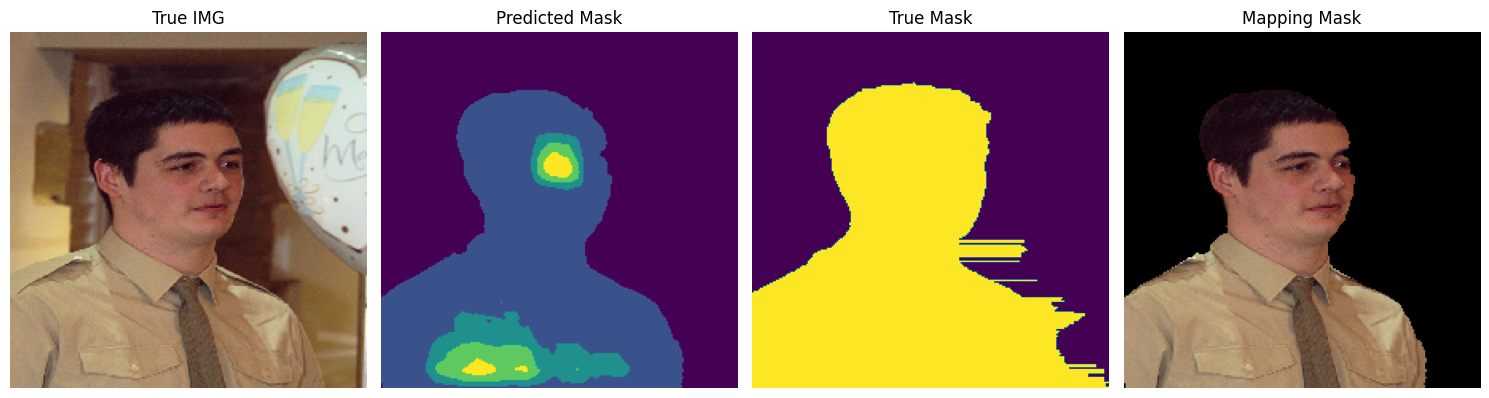

725/725 ━━━━━━━━━━━━━━━━━━━━ 424s 581ms/step - IoU: 0.7573 - accuracy: 0.9899 - loss: 0.0279 - val_IoU: 0.7467 - val_accuracy: 0.9886 - val_loss: 0.0369 - learning_rate: 9.0000e-05
Epoch 22/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.7593 - accuracy: 0.9900 - loss: 0.027


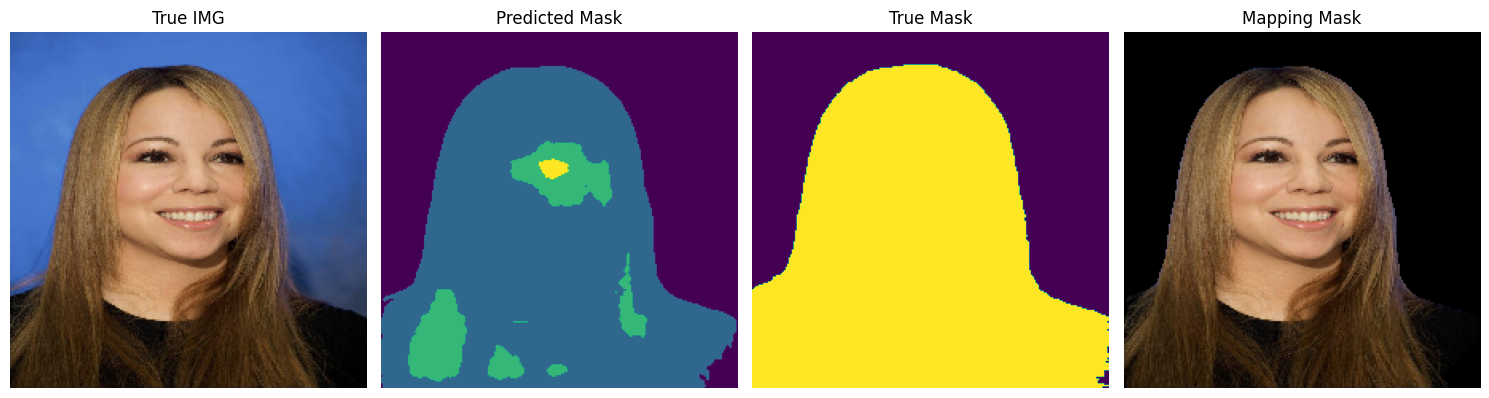

725/725 ━━━━━━━━━━━━━━━━━━━━ 446s 611ms/step - IoU: 0.7591 - accuracy: 0.9900 - loss: 0.0277 - val_IoU: 0.7487 - val_accuracy: 0.9887 - val_loss: 0.0377 - learning_rate: 9.0000e-05
Epoch 23/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step/step - IoU: 0.7659 - accuracy: 0.9905 - loss: 0.026


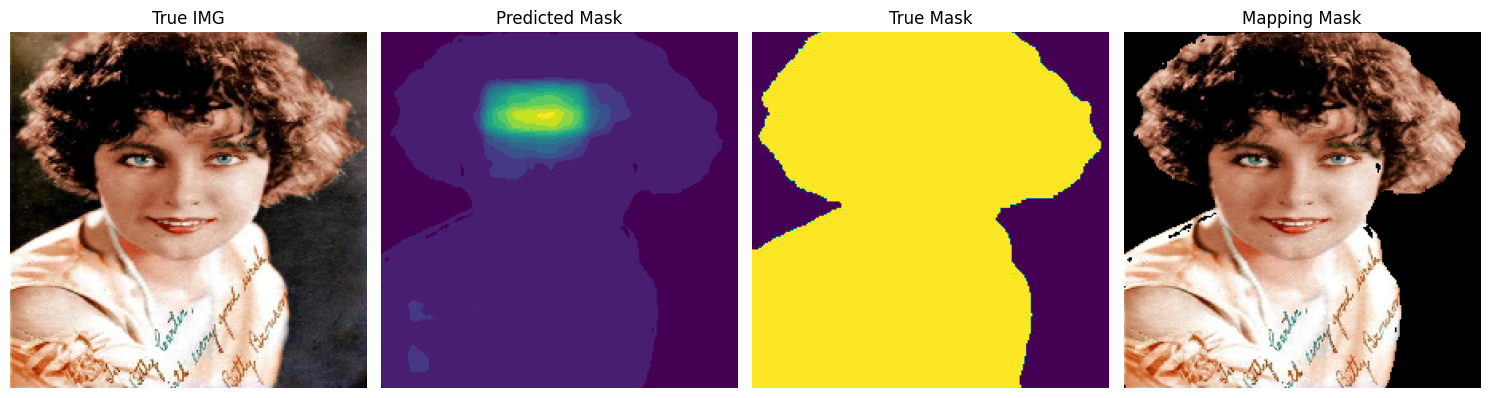

725/725 ━━━━━━━━━━━━━━━━━━━━ 445s 610ms/step - IoU: 0.7656 - accuracy: 0.9905 - loss: 0.0265 - val_IoU: 0.7526 - val_accuracy: 0.9889 - val_loss: 0.0365 - learning_rate: 9.0000e-05
Epoch 24/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step/step - IoU: 0.7718 - accuracy: 0.9908 - loss: 0.025


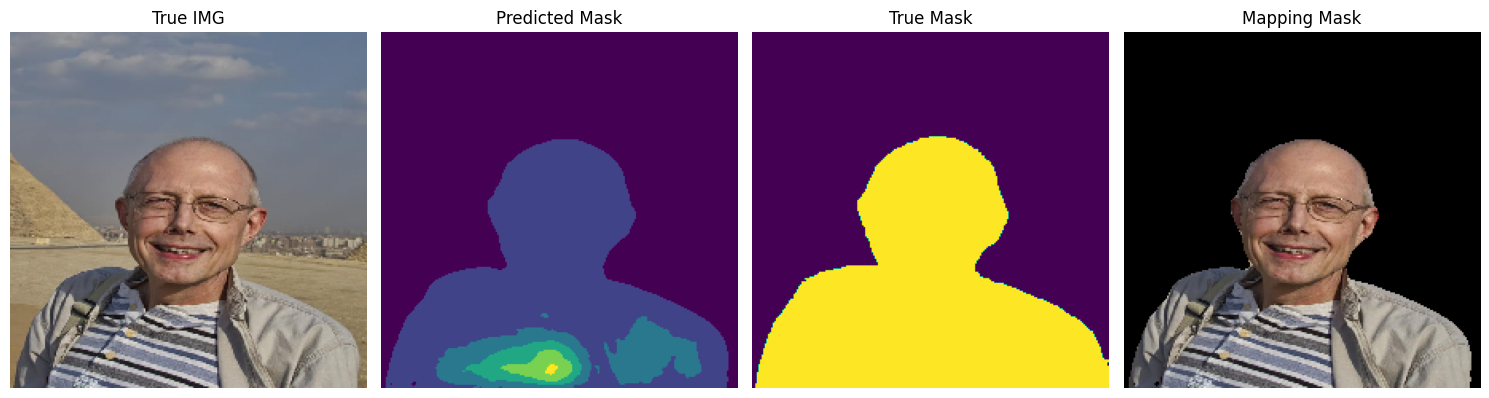

725/725 ━━━━━━━━━━━━━━━━━━━━ 436s 597ms/step - IoU: 0.7715 - accuracy: 0.9908 - loss: 0.0256 - val_IoU: 0.7558 - val_accuracy: 0.9891 - val_loss: 0.0372 - learning_rate: 9.0000e-05
Epoch 25/40
725/725 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - IoU: 0.7667 - accuracy: 0.9904 - loss: 0.0263

In [ ]:
segmodel.compile(optimizer="nadam", loss="binary_crossentropy", metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[1], name="IoU"), 'accuracy']) #ids =1
epochs = 40
hist = segmodel.fit(generator, epochs=epochs, batch_size=32, callbacks=[callback], validation_data=valid)

## Metrics

In [ ]:
res_val = segmodel.evaluate(valid)

In [ ]:
res_test = segmodel.evaluate(generator)

In [ ]:
plt.figure(figsize=(20, 7))
plt.subplot(1,3,1)

# summarize history for accuracy
plt.subplot(1,3,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,2)
plt.plot(hist.history['IoU'])
plt.plot(hist.history['val_IoU'])

plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,3,3)
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [14]:
valid_mini = DataGenerator(X_test[0:9] ,y_test[0:9], batch_size=7, dim=(224,224,3))
mini_pred = segmodel.predict(valid_mini)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


I0000 00:00:1725616563.963866     143 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


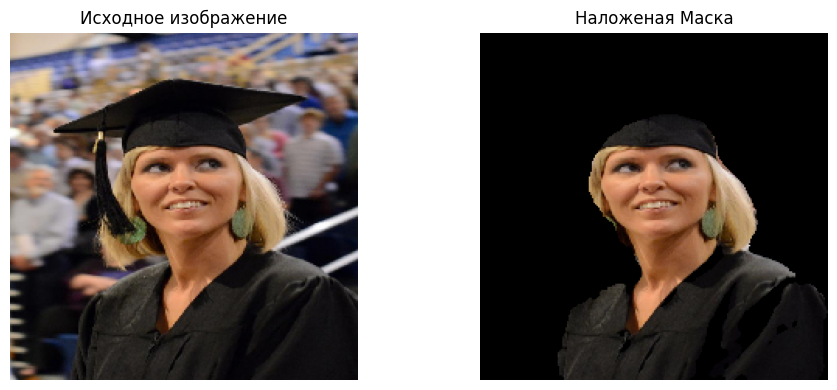

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


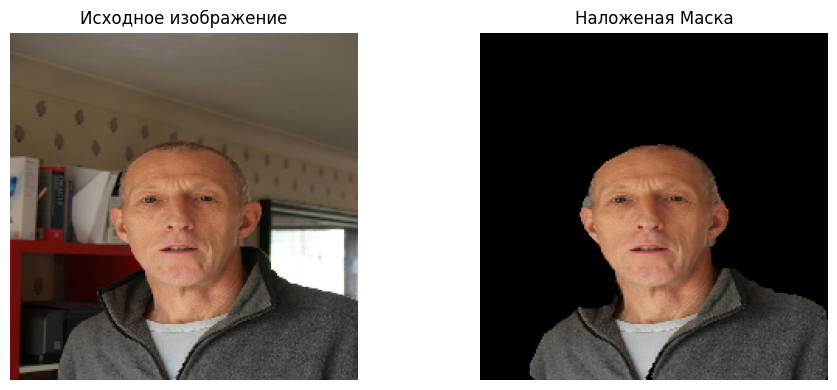

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


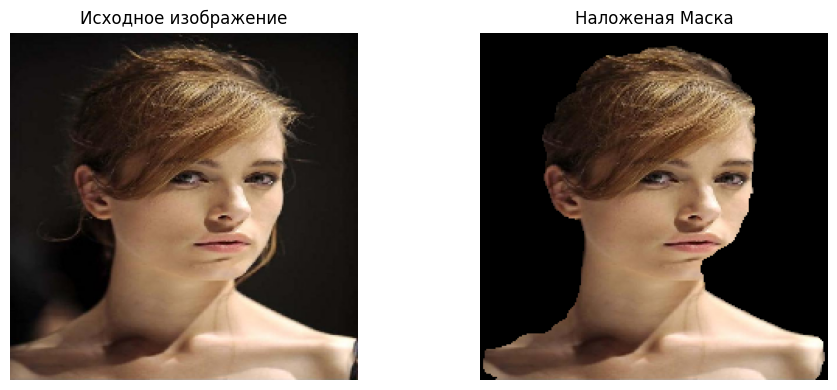

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


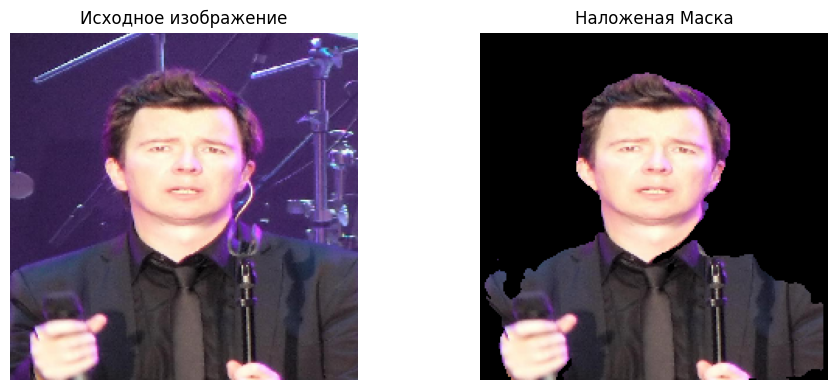

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


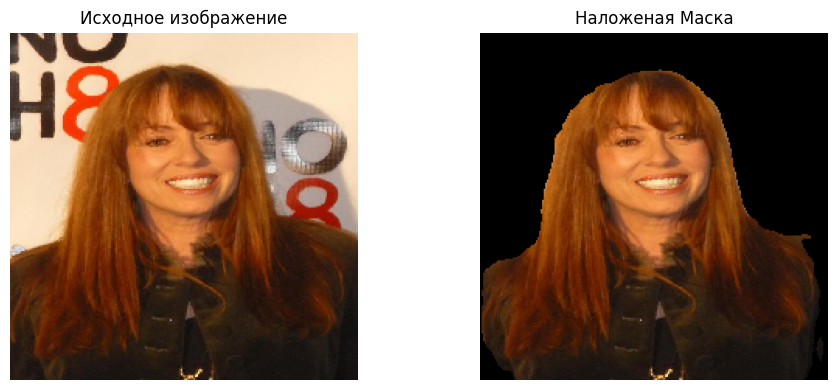

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


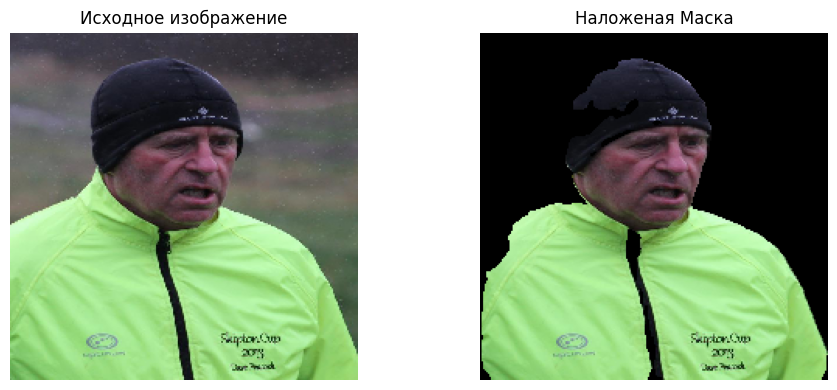

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


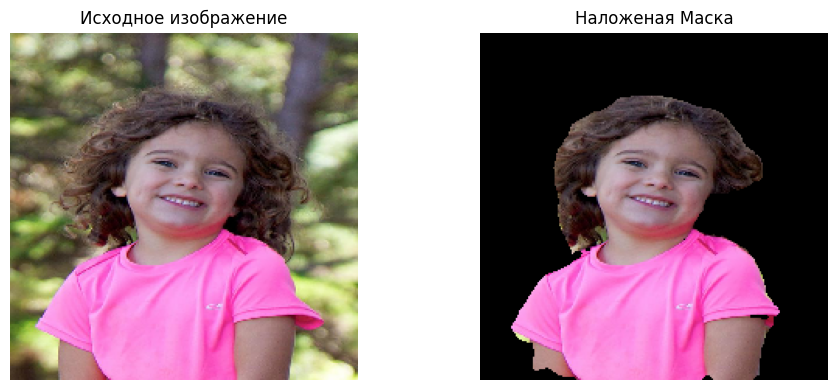

In [16]:
for i in range(len(mini_pred)):
    plt.figure(figsize=(10,4))
    img = valid_mini[0][0][0:7] # так как метод предикт принимает только от 2х и более картинок
    pred_mask = segmodel.predict(img)[i] #[i-1]
        
    pred_mask = np.array(pred_mask, dtype="uint8").reshape(224,224)
    mapping = cv.bitwise_and(img[i],img[i],mask=pred_mask)#[0]  i-2 i-2

    plt.subplot(1,2,1)
    ShowImage(img[i],title="Исходное изображение")
    
    plt.subplot(1,2,2)
    ShowImage(mapping, title="Наложеная Маска")
    
    plt.tight_layout()
    plt.show()

## Save

In [95]:
segmodel.save('/kaggle/models/segmodel.h5')

In [66]:
download_file('/kaggle/working/', 'bg_hum_model_v2_5_efb0_24e_2_14.h5')

/kaggle/working/bg_hum_model_v2_5_efb0_24e_2_14.h5.zip

In [272]:
segmodel.save('/kaggle/models/models/segmodel.h5')